# Image Compression for Stylized Images - Dimensionality Reduction

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io scikit-image


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
from sklearn.manifold import TSNE


#

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


2022-09-24 06:12:39.523833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:39.524257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:39.676570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:39.676783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:39.676972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


925340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:39.925483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:42.926876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:42.927093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:42.927262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative va

In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


### Setup Result Directory
Set the output directory where all the results will be storaged.

In [5]:
root_dir = "result/stylized_dimensionality_reduction_auto_encoder"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)


## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize=0, cache_name="stylizedAECache"):
        ds = ds.cache(filename='/tmp/{0}'.format(cache_name), name=cache_name)
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float16)
        lab = tfio.experimental.color.rgb_to_lab(image)

        return lab

    nrBatches = len(train_ds)

    # Translate [0,255] -> [-1, 1]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))
    #normalized_expected_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))

    # Combined train and expected data.
    normalized_train_ds = configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE)

    #normalized_train_ds = configure_for_performance(normalized_train_ds, AUTOTUNE, 0, "stylizedAECacheTrain")

    final_normalized_train_ds = normalized_train_ds.take(int(train_size * nrBatches))

    offset_skip = int(train_size * nrBatches)
    validation_nr_batchs = int((1.0 - train_size) * nrBatches)
    normalized_test_ds = normalized_train_ds.skip(offset_skip).take(validation_nr_batchs)

    return final_normalized_train_ds, normalized_test_ds  # configure_for_performance(normalized_test_ds, AUTOTUNE, 0, "stylizedAECacheValidation")


In [7]:


BATCH_SIZE_PER_REPLICA = 24
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (128, 128)
EPOCHS = 12

data_directory_path = "data-stylized-compression/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE, 0.9)

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

print("Validation: Number of batches {0} of {1} elements".format(
    len(validation_images), BATCH_SIZE))

#
IMAGE_SIZE = (128, 128, 3)


Found 1263538 files belonging to 1 classes.
Train: Number of batches 23691 of 48 elements
Validation: Number of batches 2632 of 48 elements


## Augment DataSet
By augmenting the image, it can reduce overfitting since no image will be the same between each epoch.

In [8]:
trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.65)
])

def AgumentFunc(x, y):
    aX = trainAug(x)
    return (aX, aX)

# apply augmentation image transformation to prevent overfitting of
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
)

train_images = train_images.prefetch(tf.data.AUTOTUNE)
trainAugmentedDS = trainAugmentedDS.prefetch(tf.data.AUTOTUNE)
validation_images = validation_images.prefetch(tf.data.AUTOTUNE)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_images = train_images.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
trainAugmentedDS = trainAugmentedDS.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
validation_images = validation_images.with_options(options)



# Example Data

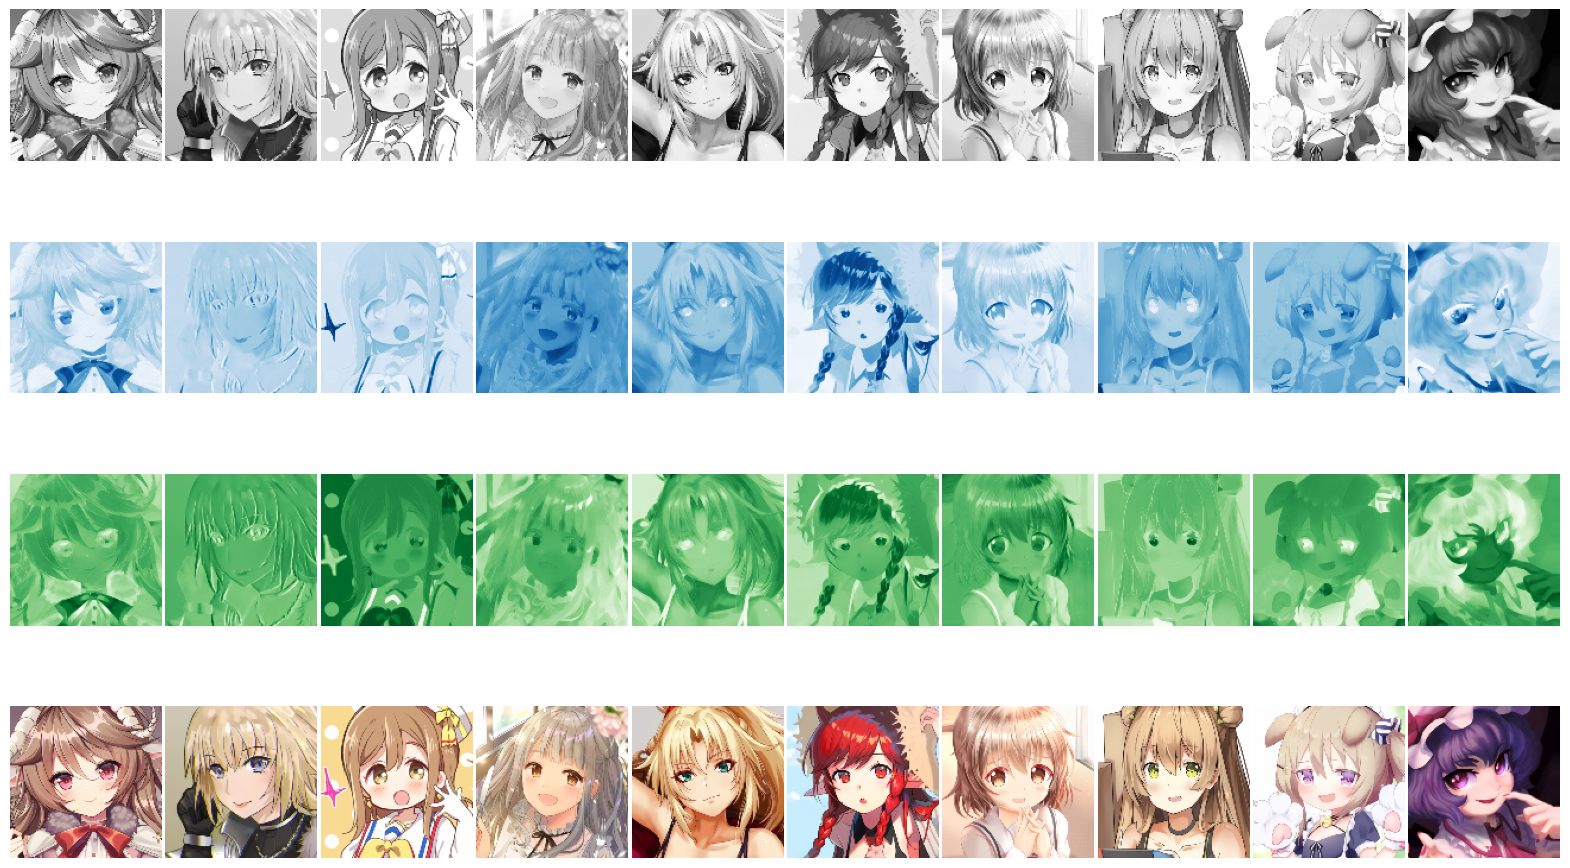

In [9]:
bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)


nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Augmented DataSet
Creates altered image to prevent overfitting

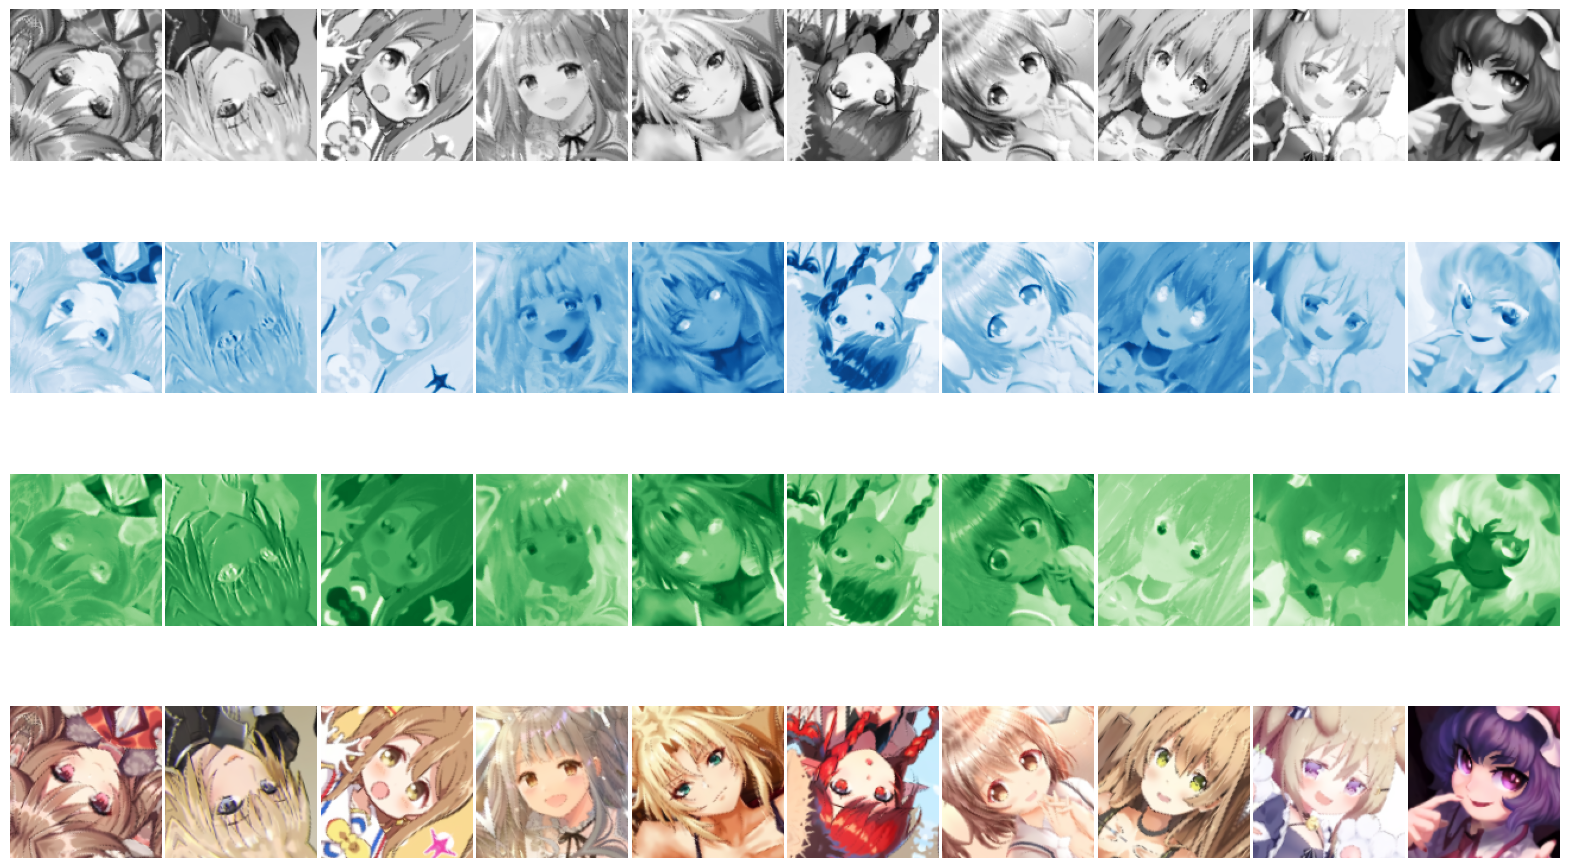

In [10]:
bathc_iter = iter(trainAugmentedDS)
image_batch, expected_batch = next(bathc_iter)

nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


# Create Model

In [11]:
def generate_cnn_builder(hp, image_size):
    def create_activation(activation):
        if activation == "leaky_relu":
            return layers.LeakyReLU(alpha=0.2, dtype='float32')
        elif activation == "relu":
            return layers.ReLU(dtype='float32')
        elif activation == "sigmoid":
            return layers.Activation(activation='sigmoid', dtype='float32')
        else:
            assert "Should never be reached"

    class Autoencoder(keras.Model):
        def __init__(self, hp, image_size, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            batch_norm = hp.Boolean('batch_norm')

            #upsample = hp.Boolean('upsample')
            use_resnet = hp.Boolean('resnet')
            transpose_conv = hp.Boolean('transpose_conv')

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'leaky_relu', 'sigmoid'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=3, max_value=6, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=5, max_value=6, step=1)

            regularization = hp.Int(
                'regularization', min_value=4, max_value=6, step=1)

            encoder_last_conv2 = None

            self.encoder = layers.Input(shape=image_size)

            x = layers.Conv2D(2 ** (hp_kernel_filter_size_l1), hp_kernel_size, strides=1, padding='same', kernel_initializer=kernel_init)(self.encoder)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            x = layers.ReLU(dtype='float32')(x)

            lastSumLayer = x

            for i in range(0, number_layers):
                filter_size = 2 ** (i + hp_kernel_filter_size_l1)
                filter_size = min(filter_size, 1024)

                x = layers.Conv2D(filter_size, hp_kernel_size, strides=1, padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                x = layers.Conv2D(filter_size, hp_kernel_size, padding='same', strides=1, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                x = layers.Conv2D(filter_size, hp_kernel_size, padding='same', strides=2, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                AttachLayer = x
                if use_resnet:
                    if lastSumLayer is not None:
                        lastSumLayer = layers.Conv2D(filters=filter_size, kernel_size=(1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                        encoder_last_conv2 = lastSumLayer
                        x = layers.add([AttachLayer, lastSumLayer])

                    x = create_activation(kernel_activation)(x)
                lastSumLayer = x

            connect_conv_shape = encoder_last_conv2.shape

            # Flatten to connect to forward neuron.
            x = layers.ActivityRegularization(l1=10 ** -regularization)(x)

            x = layers.Flatten(name='latentspace')(x)

            self.decoder = layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3]), )(x)
            x = self.decoder

            lastSumLayer = x
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 + number_layers - i - 1)
                filter_size = min(filter_size, 1024)

                if transpose_conv:
                    x = layers.Conv2DTranspose(filters=filter_size, kernel_size=hp_kernel_size, strides=(2, 2),
                                               padding='same', kernel_initializer=kernel_init)(x)
                else:
                    x = tf.nn.depth_to_space(x, 2, data_format='NHWC')
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
                #x = layers.UpSampling2D(size=(2, 2))(x)

                x = layers.Conv2D(filter_size, hp_kernel_size, padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                x = layers.Conv2D(filter_size, hp_kernel_size, padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = create_activation(kernel_activation)(x)

                AttachLayer = x
                if use_resnet:
                    if lastSumLayer is not None:
                        lastSumLayer = layers.Conv2DTranspose(filters=filter_size, kernel_size=(1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                        x = layers.add([AttachLayer, lastSumLayer])
                    x = create_activation(kernel_activation)(x)
                lastSumLayer = x

            x = layers.Conv2D(filters=3, kernel_size=(9, 9), padding='same', kernel_initializer=kernel_init)(x)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            self.decoderOutput = layers.Activation(activation='tanh', dtype='float32')(x)

        def compile(self, optimizer, **kwargs):
            super(Autoencoder, self).compile(**kwargs)
            self.optimizer = optimizer

    autoencoder = Autoencoder(hp, image_size)

    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 2e-4, 5e-4])
    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    ae_encoder_input = autoencoder.encoder
    ae_decoder_output = autoencoder.decoderOutput

    conv_autoencoder = keras.Model(inputs=ae_encoder_input, outputs=ae_decoder_output)

    def ssim_loss(y_true, y_pred):
        return 1.0 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + 0.2 * tf.keras.losses.mean_squared_error(y_true, y_pred)

    conv_autoencoder.compile(optimizer=optimizer, loss=ssim_loss, metrics=['accuracy'])

    return conv_autoencoder


## Hyperparameter

In [12]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    batch_iter = iter(batchImage)
    image_batch, _ = next(batch_iter)

    fig = plt.figure(figsize=(maxNumImages * 2, 5 * 2))
    for i in range(nrElements):

        ax = plt.subplot(5, maxNumImages, i + 1)
        plt.imshow((asarray(lab2rgb(image_batch[i % len(image_batch)] * 128)).astype(dtype='float32')))
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 1 + i + 1)
        plt.imshow(output[i, :, :, 0], cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 2 + i + 1)
        plt.imshow(output[i, :, :, 1], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 3 + i + 1)
        plt.imshow(output[i, :, :, 2], cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 4 + 1 + i)
        plt.imshow(asarray(lab2rgb(output[i])).astype(dtype='float32'))
        plt.axis("off")

        if len(image_batch) - 1 == i:
            image_batch, _ = next(batch_iter)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData.take(12)
        self.dir_path = dir_path
        self.latent_space = latent_space
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig(os.path.join(self.dir_path, "StylizedCompression{0}_{1}.png".format(self.latent_space, epoch)))
        fig = showResult(self.model, self.trainSet, 14)
        fig.savefig(os.path.join(self.dir_path, "StylizedCompressionBig{0}_{1}.png".format(self.latent_space, epoch)))


In [13]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print('Train Image Size: ' + str(image_shape))


def hyperparamter_model_builder(hp):
    model = generate_cnn_builder(hp, image_shape)
    tf.keras.utils.plot_model(
        model, to_file=os.path.join(root_dir, str.format('cnn_{0}_model.png', "Compression")), show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None
    )
    return model

class SaveTrailImageResultCallback(tf.keras.callbacks.Callback):

    def __init__(self, tuner, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.tuner = tuner

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        state = self.tuner.get_state()
        fig = showResult(self.model, trainAugmentedDS.take(2))
        index = 0
        if len(self.tuner.oracle.start_order) > 0:
            index = self.tuner.oracle.start_order[-1]
        fig.savefig(os.path.join(self.tuner.get_trial_dir(index), str.format('ImageAtEpoch{0}.png', epoch)))


tuner = kt.Hyperband(hyperparamter_model_builder,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=8,
                     distribution_strategy=strategy,
                     factor=5,
                     directory=os.path.join(root_dir, 'cache'),
                     project_name=str.format('Stylized AutoEncoder - {0}', "Compression"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)

tuner.search(trainAugmentedDS.take(250), epochs=EPOCHS,
             validation_data=trainAugmentedDS.skip(250).take(50),
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN(), SaveTrailImageResultCallback(tuner)], verbose=1)

# Get bets models.
best_models = tuner.get_best_models(num_models=8)


Trial 6 Complete [00h 06m 18s]
val_accuracy: 0.9522917866706848

Best val_accuracy So Far: 0.9522917866706848
Total elapsed time: 01h 48m 27s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
False             |False             |batch_norm
True              |True              |transpose_conv
normal            |lecun_uniform     |kernel_initializer
relu              |relu              |kernel_activation
6                 |3                 |kernel_filter
5                 |4                 |kernel_size
6                 |5                 |number_layers
5                 |5                 |regularization
adam              |adam              |optimizer
0.002             |0.0005            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


250/250 [==============================] - 1702s 7s/step - loss: 662.1257 - accuracy: 0.9248 - val_loss: 0.5707 - val_accuracy: 0.9521
Epoch 2/2
 11/250 [>.............................] - ETA: 24:04 - loss: 0.5659 - accuracy: 0.9533

In [ ]:
model_results = []
latent_spaces = []

EPOCHS = 2

for ae_model in best_models:

    latent_space = ae_model.get_layer("latentspace").output_shape[1]
    latent_spaces.append(latent_space)

    checkpoint_path = os.path.join(root_dir, str.format("checkpoints/cp_{0}.ckpt", latent_space))

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    autoencoder_history = ae_model.fit(trainAugmentedDS,
                                       epochs=EPOCHS,
                                       shuffle=True, callbacks=[cp_callback, save_images(os.path.join(root_dir, str.format("stylized_compression_latent_{0}", latent_space)), latent_space, train_images)])

    ae_model.save_weights(checkpoint_path)

    # Save Model
    ae_model.save(os.path.join(root_dir, "stylized_compression_l{0}/stylized-autoencoder.h5".format(latent_space)))

    encoder_model = keras.Model(inputs=ae_model.inputs, outputs=ae_model.get_layer(name="latentspace").output)
    decoder_model = keras.Model(inputs=layers.Input(tensor=ae_model.get_layer(name="latentspace").output), outputs=ae_model.outputs)

    encoder_model.save(os.path.join(root_dir, "stylized_compression_l{0}/stylized-encoder.h5".format(latent_space)))
    decoder_model.save(os.path.join(root_dir, "stylized_compression_l{0}/stylized-decoder.h5".format(latent_space)))


Epoch 1/2
23691/23691 [==============================] - 32780s 1s/step - loss: 0.0333 - accuracy: 0.9471
Epoch 2/2
14500/23691 [=================>............] - ETA: 3:20:39 - loss: 0.0217 - accuracy: 0.9376

## Result
The result is both in how good the model reconstruct as well how much of a compression ratio it would yield.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]
    print("Latent Space ", latent_space_size)

    result = ae_model.evaluate(validation_images, batch_size=BATCH_SIZE, verbose=0)
    print("loss, accuracy ", result)


Latent Space  16


2022-08-05 01:29:47.916093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-05 01:44:08.686523: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


loss, accuracy  [0.02514222264289856, 0.9385086297988892]
Latent Space  16
loss, accuracy  [0.042462099343538284, 0.9161767363548279]
Latent Space  16
loss, accuracy  [0.3058066666126251, 0.9384972453117371]
Latent Space  4096
loss, accuracy  [0.20533522963523865, 0.9396572113037109]
Latent Space  16
loss, accuracy  [0.3735292851924896, 0.9385086297988892]
Latent Space  4096
loss, accuracy  [0.017375117167830467, 0.9477706551551819]


In [ ]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "Stylized Compression Performance History"))


<Figure size 0x3000 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
for ae_model in best_models:
    showResult(ae_model, train_images, 8)


## Plot Dimensional Reduction

In [ ]:
# Plot Result
fig = plt.figure(figsize=(len(best_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, best_models)):
    ax = plt.subplot(1, len(best_models), i + 1)
    encoder_model = model.layers[1]
    latent_value = encoder_model.predict(train_images, batch_size=256, verbose=0)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)))
        plt.colorbar()
plt.show(block=False)


## Compression Ratio
Since the purpose of dimmension reduction is for creating a lossy compression that hopefully has a lower size than either the jpg/png. In respect to the level lossy.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]

    raw_image_size_byte = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    latent_space_byte = latent_space_size * 4
    compression_ratio = float(raw_image_size_byte) / float(latent_space_byte)

    # Compute error.
    print("Compression Ratio", compression_ratio)


Compression Ratio 1.5


In [ ]:
for ae_model in best_models:
    validation_latent_spaces = []
    for batch in validation_images:
        train, expected = batch
        encoder_model = model.layers[1]
        latent_space = encoder_model.predict(train, verbose=0)
        validation_latent_spaces.append(latent_space)

    compressed_file_path = os.path.join(root_dir, 'latent_space.npy')
    validation_latent_spaces = np.asarray(validation_latent_spaces).flatten()
    np.save(compressed_file_path, validation_latent_spaces)

    raw_latent_space_size_byte = len(validation_latent_spaces) * 4
    compressed_latent_space_size_byte = os.path.getsize(compressed_file_path)
    compression_ratio = float(raw_latent_space_size_byte) / float(compressed_latent_space_size_byte)
    print("Raw Latent space", raw_latent_space_size_byte)
    print("Compressed Latent space", compressed_latent_space_size_byte)
    print("Compression Ratio", compression_ratio)


Raw Latent space 21756903424
Compressed Latent space 10878451840
Compression Ratio 1.9999999764672396


## Episode Improvement Transition

In [ ]:
anim_file = os.path.join(root_dir, 'stylized-compression.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(root_dir, 'StylizedCompression*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


## Present LatentSpace

In [ ]:
import scipy
import moviepy.editor


In [ ]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [ ]:
def generate_transition(model, latent_space, grid_size):
    nr_elemenets = 4
    seeds = np.random.randint(10000, size=2)
    zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
          for s in seeds]

    all_latents = interpolate(zs, nr_elemenets)

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(grid_size[0] * 2, grid_size[1] * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(grid_size[0], grid_size[1], i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()


In [ ]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


In [ ]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

for ae_model in best_models:

    latent_space = ae_model.get_layer("latentspace").output_shape[1]

    shape = [num_frames, np.prod(latent_space_size)]

    nr_elemenets = 16

    seeds = np.random.randint(10000, size=2)
    zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
          for s in seeds]

    all_latents = interpolate(zs, num_frames)

    def make_frame(t):
        frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
        latents = all_latents[frame_idx]

        # Generate figure in respect new latent pace
        fig = generate_grid_image(ae_model.layers[2], latents, (5, 5), (4, 4))

        # Convert figure to bitmap.
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return data


gif_filepath = os.path.join(root_dir, 'autoencoder_l{0}_stylized_compression_transition_grid_{1}.gif'.format(latent_space, seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file autoencoder_stylized_compression_transition_grid_1802.gif with imageio.


In [ ]:
Image(url=gif_filepath)

In [ ]:
# Transition between two sets of images.
for i, (lantent_space, model) in enumerate(zip(latent_spaces, best_models)):

    encoder_model = model.getEncoder()
    latent_value0 = encoder_model.predict(train_images.take(1), batch_size=9, verbose=0)

    latent_value1 = encoder_model.predict(train_images.skip(1).take(1), batch_size=9, verbose=0)

    nr_elemenets = 16

    all_latents = interpolate([latent_value0, latent_value1], num_frames)

    def make_frame(t):
        frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
        latents = all_latents[frame_idx]

        # Generate figure in respect new latent pace
        fig = generate_grid_image(model.getDecoder(), latents, (5, 5), (4, 4))

        # Convert figure to bitmap.
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return data

    gif_filepath = os.path.join(root_dir, ('stylized_dims_reduction_transition_grid_I{0}.gif'.format(lantent_space)))
    video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
    video_clip.write_gif(gif_filepath, fps=fps)
    Image(url=gif_filepath)

In [ ]:
for ae_model in best_models:
    ae_model.summary()
    ae_model.layers[1].summary()
    ae_model.layers[2].summary()
